In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
dataset = pd.read_csv('../secondMMRintData/zfixed3brfill.csv')

In [3]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [4]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 7.38 s, sys: 101 ms, total: 7.48 s
Wall time: 7.48 s


In [5]:
dataset['EMavg'] = (dataset['EMcrossfar']+dataset['EMcrossnear']+dataset['EMcrossouter'])/3

In [6]:
dataset['Widavg']= (dataset['MMRstrengthWnear']+dataset['MMRstrengthWfar']+dataset['MMRstrengthWouter'])/3

In [7]:
dataset


,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
0,0,0.221502,0.098431,9.878834e-03,0.013642,0.007103,0.300893,0.093415,0.001595,0.003112,...,0.053981,0.007530,0.004649,True,False,1.235665e+07,8.315223e+07,0,0.370479,0.009765
1,1,0.190647,0.009185,1.703367e-03,0.019474,0.015939,0.403777,0.249341,0.003783,0.008003,...,0.017682,0.082772,0.071393,True,False,1.348749e+05,2.133072e+05,0,0.421943,0.009333
2,2,0.125660,0.426660,1.310313e-01,0.033117,0.022168,0.720557,0.000531,0.000266,0.000287,...,0.042240,0.054516,0.051803,True,False,1.276428e+04,9.321863e+03,0,0.594326,0.013826
3,3,0.216684,0.002876,1.857040e-07,0.004557,0.001577,0.235460,0.027521,0.013379,0.001208,...,0.013245,0.057501,0.040897,True,True,1.000000e+09,1.000000e+09,0,0.318436,0.002047
4,4,0.024455,0.423830,1.145611e-01,0.002436,0.000582,0.034058,0.079484,0.053510,0.003246,...,0.006777,0.011759,0.007401,True,False,8.791890e+01,8.791890e+01,0,0.039287,0.002854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.447117,2.475049e-02,0.016075,0.016330,0.664222,0.001175,0.000000,0.004940,...,0.098020,0.132139,0.073446,True,False,6.990387e+05,8.267916e+05,0,0.515834,0.007714
138539,138539,0.251338,0.749336,1.701463e-03,0.003767,0.002099,0.272822,0.017013,0.004713,0.007723,...,0.017757,0.043224,0.003523,True,False,3.075749e+08,6.576003e+08,0,0.372297,0.005352
138540,138540,0.131799,0.324267,2.940005e-02,0.017772,0.017278,0.366664,0.059764,0.006983,0.001049,...,0.064086,0.047189,0.045870,True,False,1.193822e+07,3.363291e+07,0,0.348418,0.014406
138541,138541,0.209454,1.205802,5.207774e-02,0.033014,0.057969,0.395073,0.029166,0.002591,0.020718,...,0.091233,0.217038,0.183490,True,False,2.064407e+08,4.316851e+07,0,0.430601,0.028591


In [8]:


twoBRwidth = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter','twoMMRstrengthWnear','twoMMRstrengthWfar','twoMMRstrengthWouter']
twoBRinW = ['MMRinWidnear','MMRinWidfar','MMRinWidouter','twoMMRinWidnear','twoMMRinWidfar','twoMMRinWidouter']

OGfeatures = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','MEGNO', 'MEGNOstd']



MMRDATAplus = ['MMRstrengthnear','MMRstrengthfar','MMRstrengthouter', 'EMcrossnear','EMcrossfar','EMcrossouter','eccMag','eccDir','pomegastd','added'
           ]+twoBRwidth

TestFirst = ['threeBRfillfac', 'threeBRfillstd','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter']

testfew = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter', 'threeBRfillfac','EMcrossnear','EMcrossfar','EMcrossouter']

testavg = ['EMavg','Widavg','threeBRfillfac']

orbital = []
e = []
a = []
P = []
pomega = []
Omega = []
w = []
m = []
for x in ['1','2','3']:
    e.append('e'+x)
    a.append('a'+x)
    P.append('P'+x)
    pomega.append('pomega'+x)
    Omega.append('Omega'+x)
    w.append('w'+x)
    m.append('m'+x)
orbital = e + a + P + pomega + Omega + w + m

MMRDATA = ['threeBRfillfac','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter', 'EMcrossnear','EMcrossfar','EMcrossouter','eccMag','eccDir','pomegastd', "3BRfirstfillfac"
           ]+twoBRwidth+e

noEM = ['threeBRfillfac','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','eccMag','eccDir','pomegastd', "3BRfirstfillfac"
           ]+twoBRwidth

In [9]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [10]:
filtData['added'] = filtData['threeBRfillfac']+filtData['3BRfirstfillfac']

In [11]:
scrambled = filtData.sample(frac=1)

In [12]:
scrambled = scrambled.reset_index()

In [13]:
scrambled

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,...,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,added
0,25697,25697,0.054848,1.295877,0.010577,0.002305,0.002321,0.242365,0.011169,6.053300e-03,...,0.061120,0.017333,True,False,2.775951e+07,4.638412e+07,0,0.202573,0.005267,1.076866
1,113386,113386,0.059949,0.595473,0.046262,0.005928,0.009649,0.269387,0.000905,4.372812e-04,...,0.071587,0.033682,True,True,1.000000e+09,1.000000e+09,0,0.224940,0.003072,0.226461
2,91987,91987,0.178033,0.015914,0.008890,0.015458,0.011831,0.405872,3.971579,4.570342e-03,...,0.104923,0.098105,True,True,1.000000e+09,1.000000e+09,0,0.413356,0.008554,0.179147
3,71466,71466,0.045872,0.045495,0.033149,0.003040,0.000610,0.554141,0.020956,5.135690e-07,...,0.018610,0.000295,True,False,5.188344e+04,7.029355e+02,0,0.408482,0.005309,1.558272
4,14666,14666,0.113810,0.001690,0.000729,0.000240,0.000247,0.166265,0.001771,2.610927e-05,...,0.003088,0.000743,True,True,1.000000e+09,1.000000e+09,0,0.193024,0.000296,0.050405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,53038,53038,0.108509,2.703723,0.040755,0.019852,0.020419,0.211824,1.064942,2.510813e-03,...,0.112667,0.024667,True,False,8.477879e+04,9.181556e+04,0,0.221217,0.012086,3.928053
138539,63723,63723,0.212644,0.833161,0.009048,0.014118,0.008319,0.228861,0.044634,2.980470e-02,...,0.140636,0.147286,True,False,1.542514e+05,1.716951e+04,0,0.310559,0.009918,0.281985
138540,53785,53785,0.040107,0.133552,0.039800,0.000832,0.002071,0.116313,0.010817,8.208585e-03,...,0.007824,0.006012,True,False,2.984396e+04,1.050004e+03,0,0.105835,0.002176,11.534224
138541,11931,11931,0.030009,0.271986,0.014739,0.006092,0.006081,0.190886,0.083423,1.717964e-02,...,0.037984,0.031044,True,False,1.323287e+01,1.323287e+01,0,0.149173,0.002929,26.304554


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [14]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]


# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [15]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [16]:
realTest = test.loc[test['prelimStable']==True]

In [17]:
testT = realTest.loc[test['Stable'] == True]
testF = realTest.loc[test['Stable'] == False]


In [18]:
tT = pd.concat([testT, testF.sample(n=7300)])
tT = tT.sample(frac=1)

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
train

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,...,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,added
0,25697,25697,0.054848,1.295877,0.010577,0.002305,0.002321,0.242365,0.011169,6.053300e-03,...,0.061120,0.017333,True,False,2.775951e+07,4.638412e+07,0,0.202573,0.005267,1.076866
1,113386,113386,0.059949,0.595473,0.046262,0.005928,0.009649,0.269387,0.000905,4.372812e-04,...,0.071587,0.033682,True,True,1.000000e+09,1.000000e+09,0,0.224940,0.003072,0.226461
2,91987,91987,0.178033,0.015914,0.008890,0.015458,0.011831,0.405872,3.971579,4.570342e-03,...,0.104923,0.098105,True,True,1.000000e+09,1.000000e+09,0,0.413356,0.008554,0.179147
3,71466,71466,0.045872,0.045495,0.033149,0.003040,0.000610,0.554141,0.020956,5.135690e-07,...,0.018610,0.000295,True,False,5.188344e+04,7.029355e+02,0,0.408482,0.005309,1.558272
4,14666,14666,0.113810,0.001690,0.000729,0.000240,0.000247,0.166265,0.001771,2.610927e-05,...,0.003088,0.000743,True,True,1.000000e+09,1.000000e+09,0,0.193024,0.000296,0.050405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110829,1356,1356,0.340564,0.070761,0.040110,0.019876,0.013261,0.634075,0.096779,0.000000e+00,...,0.189187,0.172299,True,False,3.437819e+04,4.034359e+04,0,0.721740,0.022496,0.162777
110830,114160,114160,0.093706,0.229843,0.011034,0.004138,0.004225,0.188977,0.010314,6.138625e-03,...,0.027956,0.012084,True,True,1.000000e+09,1.000000e+09,0,0.194358,0.002945,0.233579
110831,83155,83155,0.155825,0.020271,0.002809,0.001043,0.001001,0.182313,0.437933,1.100000e-02,...,0.003829,0.006126,True,True,1.000000e+09,1.000000e+09,0,0.234895,0.000803,0.383277
110832,61066,61066,0.093801,0.910940,0.063744,0.018385,0.021356,0.205146,0.116510,1.043660e-02,...,0.040834,0.042182,True,False,2.029891e+04,2.188401e+04,0,0.205712,0.013028,1.386535


In [23]:
testModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 200,
                         scale_pos_weight=resultBalance)

In [24]:
testModel.fit(train[MMRDATA], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [25]:
resPred = testModel.predict_proba(tT[MMRDATA])[:,1]

print (metrics.roc_auc_score(tT['Stable'],resPred))
print(accuracy_score(testModel.predict(tT[MMRDATA]), tT["Stable"]))

0.9536313216609706
0.8676258002340469


In [26]:
tT.value_counts('Stable')

Stable
False    7300
True     7227
Name: count, dtype: int64

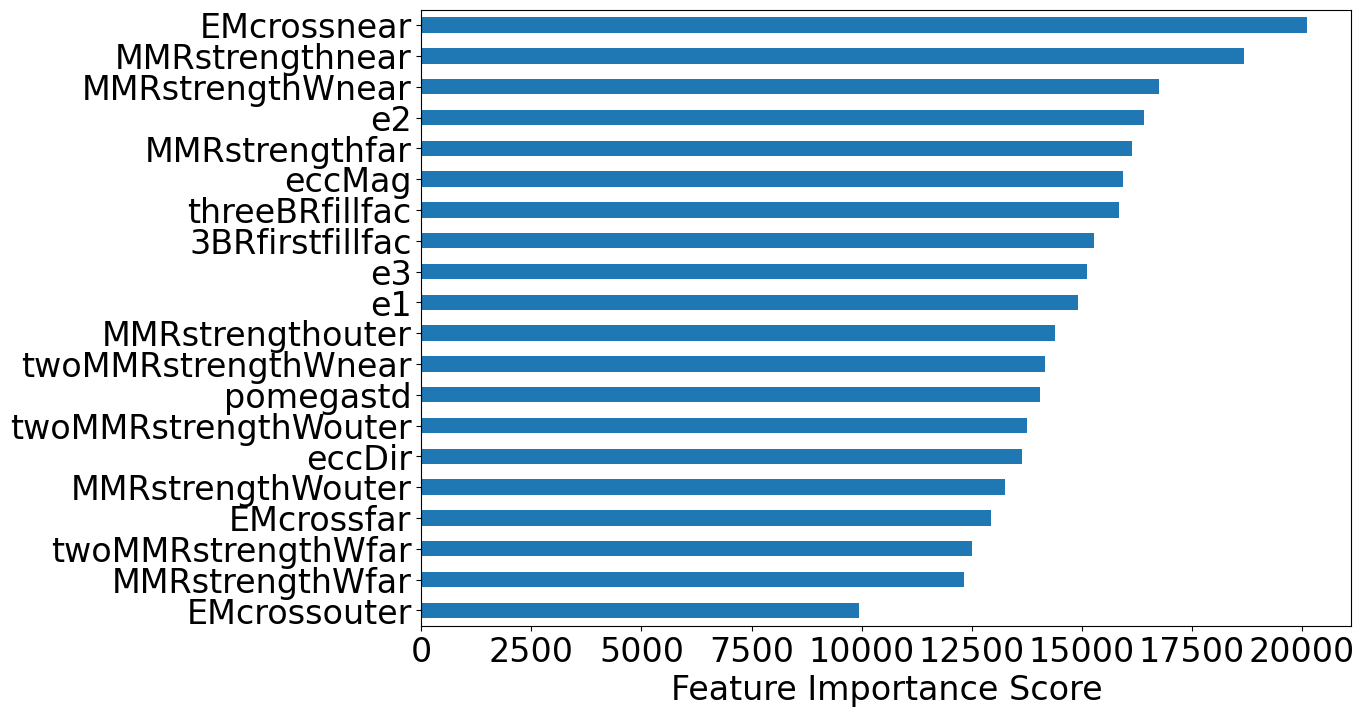

In [27]:
feat_imp = pd.Series(testModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')